In [1]:
import CTApy
import pandas as pd
import numpy as np
import random
import os

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import fasttext
import torch
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from umap import UMAP


In [2]:
# Set a seed value
seed_value = 42  # can be any number

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

torch.manual_seed(seed_value)

In [3]:
# load data
path_data=""
df = pd.read_csv(path_data+"cta_data/tdm_lemmatized.csv",sep=",",dtype=str)


path_graphs=""

In [4]:
# Prepare data for the fasttext model
data_words = df['text_lemma'].str.split().tolist()

In [5]:
# Load pre-trained model
pretrained_model = fasttext.load_facebook_model("research_data/cc.en.300.bin")

# Update the model with new data
pretrained_model.build_vocab(corpus_iterable=data_words, update=True)
pretrained_model.train(corpus_iterable=data_words, total_examples=len(data_words), epochs=pretrained_model.epochs)

(410, 2154)

In [9]:
text_lemma=df['text_lemma']
outcome=df['outcome']

In [10]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")

In [11]:
# Create a UMAP model with the seed value
# umap_model = UMAP(random_state=seed_value)
umap_model = UMAP(random_state=42)

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
# topic_model = BERTopic(umap_model=umap_model,representation_model=representation_model,embedding_model=sentence_model)
topic_model = BERTopic(umap_model=umap_model,representation_model=representation_model,nr_topics=5,calculate_probabilities=True)
# topics, probs = topic_model.fit_transform(text_lemma)
# topics, probs = topic_model.fit_transform(df['open.ended.response'])

In [12]:
# Get the topics for each document
topics,probabilities = topic_model.fit_transform(text_lemma)
# topics, _ = topic_model.fit_transform(text_lemma_tosave['text_raw'])

# Get unique topics
unique_topics = np.unique(topics)

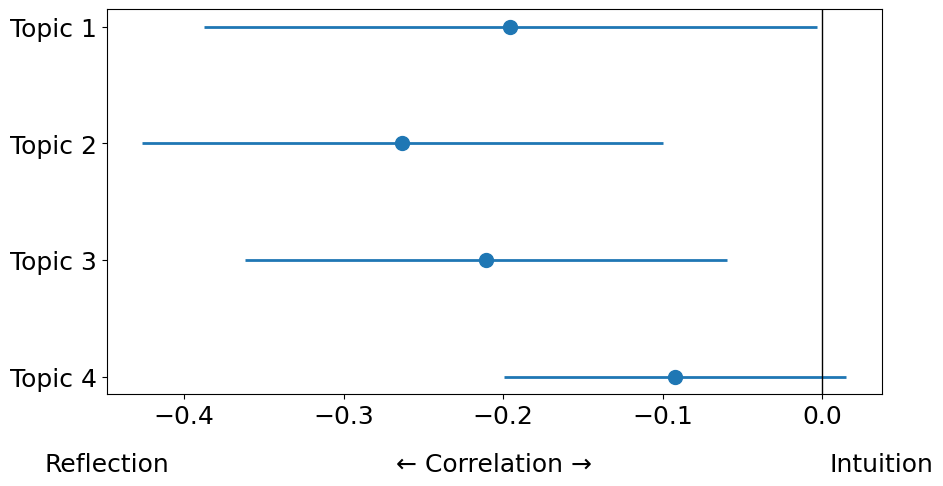

In [13]:
df = pd.DataFrame({'topic':topics,'treatment':outcome})
# Convert "topic" into dummy variables and prefix the column names with "topic_"
df_dummies = pd.get_dummies(df['topic'], prefix='topic')*1

# Check if 'topic_-1' is in the DataFrame
if 'topic_-1' in df_dummies.columns:
    # Remove 'topic_-1' column
    df_dummies = df_dummies.drop(columns='topic_-1')

# Concatenate the outcome column with the new dummy columns
df_final = pd.concat([df['treatment'], df_dummies], axis=1)

# Convert DataFrame to numeric data type
df_final = df_final.apply(pd.to_numeric, errors='coerce')
df_final.columns=['Topic 1','Topic 2','Topic 3','Topic 4','treatment'] 

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_final.columns:
    if column != 'treatment':
        X = df_final['treatment']
        y = df_final[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2
# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

topic_order=np.arange(len(coefficients),0,-1)-1

plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)
plt.yticks(topic_order, df_final.columns[df_final.columns != 'treatment'], fontsize=font_size)

# Get the current limits of the x-axis
xmin, xmax = plt.xlim()

# Define x-axis labels and their positions
labels = ['Reflection', u'\u2190 Correlation \u2192', 'Intuition']  # Unicode characters for left and right arrows
positions = [xmin, (xmin + xmax) / 2, xmax]  # Place 'Correlation' at the middle of the x-axis

# Add new x-axis labels
for pos, label in zip(positions, labels):
    plt.text(pos, -0.15, label, fontsize=font_size, ha='center', va='top', transform=plt.gca().get_xaxis_transform())

# Increase font size for original x-axis labels
plt.xticks(fontsize=font_size)

plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'bertopic_topic_tdm.png',bbox_inches='tight')
plt.show()

In [14]:
# Get the topics
topics = topic_model.get_topic_info()['Topic'].unique()

# Initialize an empty list to hold the top words for each topic
top_words_per_topic = []

# Loop over the topics
for topic in topics:
    if topic != -1:  # We skip -1 as it represents the 'unclassified' topic
        # Get the top 5 words for the topic
        top_words = [word for word, prob in topic_model.get_topic(topic)[:5]]
        # Add the top words to our list
        top_words_per_topic.append(top_words)
print(top_words_per_topic) 

[['benefit', 'contribute', 'group', 'contribution', 'interest'], ['cent', 'contribute', '40', 'contribution', 'amount'], ['belief', 'faith', 'religious', 'religion', 'prayer'], ['money', 'earn', 'dollar', 'want', 'gain']]


In [15]:
top_words_per_topic

[['benefit', 'contribute', 'group', 'contribution', 'interest'],
 ['cent', 'contribute', '40', 'contribution', 'amount'],
 ['belief', 'faith', 'religious', 'religion', 'prayer'],
 ['money', 'earn', 'dollar', 'want', 'gain']]

In [16]:
# Flatten the list of lists into a single list
all_words_bertopic_top5 = [word for sublist in top_words_per_topic for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(all_words_bertopic_top5)

# If you need a list, convert the set back to a list
all_words_bertopic_top5 = list(unique_words)



In [17]:
# cosine_matrix_bertopic=create_cosine_matrix(pretrained_model, all_words_bertopic_top5)
cosine_matrix_bertopic=CTApy.create_cosine_matrix(pretrained_model, all_words_bertopic_top5)


In [1]:
# Overall quality score BERTopic
CTApy.calculate_quality_all(top_words_per_topic, cosine_matrix_bertopic)

NameError: name 'CTApy' is not defined

In [19]:
# BTM

In [20]:
btm_tdm_topic_probabilities=pd.read_csv(
   path_data+"btm_tdm_topic_probabilities.csv"
,sep=",",dtype=str)

btm_words=pd.read_csv(path_data+"btm_tdm_top_words.csv",
                      sep=",",dtype=str)

btm_tdm_topic_probabilities['treatment']=outcome
btm_tdm_topic_probabilities=btm_tdm_topic_probabilities.drop(columns='doc')

top_words_per_topic_btm = [words[0] for words in [btm_words[col].str.split(', ').tolist() for col in btm_words.columns]]

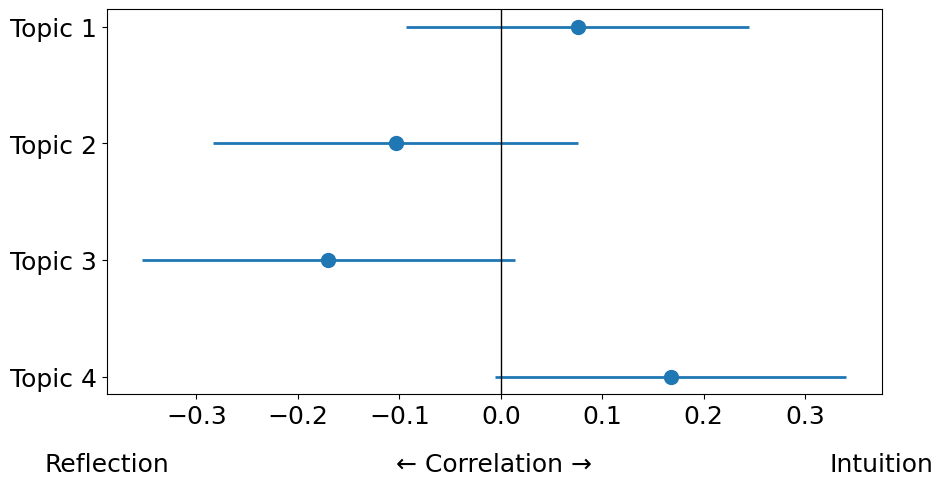

In [21]:
# Initialize an empty list to hold the average compound scores
average_scores = []

# Convert DataFrame to numeric data type

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []
btm_tdm_topic_probabilities = btm_tdm_topic_probabilities.apply(pd.to_numeric, errors='coerce')
btm_tdm_topic_probabilities.columns=['Topic 1','Topic 2','Topic 3','Topic 4','treatment'] 

# Run a linear regression for each topic dummy
for column in btm_tdm_topic_probabilities.columns:
    if column != 'treatment':
        X = btm_tdm_topic_probabilities[column]
        y = btm_tdm_topic_probabilities['treatment']
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

topic_order=np.arange(len(coefficients),0,-1)-1

plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)
plt.yticks(topic_order, 
           btm_tdm_topic_probabilities.columns[btm_tdm_topic_probabilities.columns != 'treatment'], fontsize=font_size)

# Get the current limits of the x-axis
xmin, xmax = plt.xlim()

# Define x-axis labels and their positions
labels = ['Reflection', u'\u2190 Correlation \u2192', 'Intuition']  # Unicode characters for left and right arrows
positions = [xmin, (xmin + xmax) / 2, xmax]  # Place 'Correlation' at the middle of the x-axis

# Add new x-axis labels
for pos, label in zip(positions, labels):
    plt.text(pos, -0.15, label, fontsize=font_size, ha='center', va='top', transform=plt.gca().get_xaxis_transform())

# Increase font size for original x-axis labels
plt.xticks(fontsize=font_size)
plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'btm_topic_tdm.png',bbox_inches='tight')
plt.show()

In [22]:
top_words_per_topic_btm

[['contribute', 'cent', 'good', 'group', 'money'],
 ['good', 'group', 'believe', 'like', 'decision'],
 ['people', 'cent', 'contribute', 'group', 'want'],
 ['contribute', 'people', 'feel', 'want', 'believe']]

In [23]:
# Flatten the list of lists into a single list
all_words_per_topic_btm = [word for sublist in top_words_per_topic_btm for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(all_words_per_topic_btm)

# If you need a list, convert the set back to a list
all_words_per_topic_btm = list(unique_words)

In [24]:
# Overall quality score BTM
cosine_matrix_btm=CTApy.create_cosine_matrix(pretrained_model, all_words_per_topic_btm)
CTApy.calculate_quality_all(top_words_per_topic_btm, cosine_matrix_btm)

0.1838330423080178

In [25]:
# STM

In [31]:
stm_tdm_topic_probabilities=pd.read_csv(
    path_data+"stm_tdm_topic_probabilities.csv"
,sep=",",dtype=str)

stm_words=pd.read_csv(path_data+"stm_tdm_top_words.csv",
                      sep=",",dtype=str)

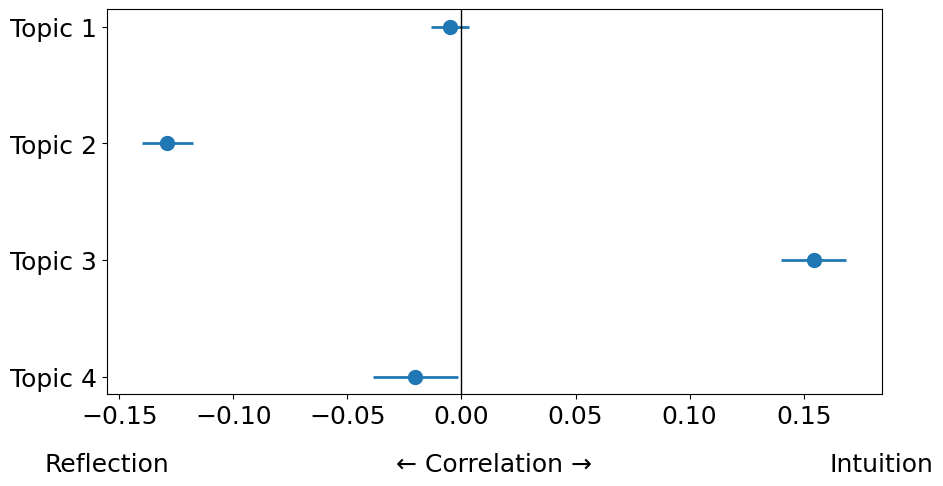

[['want', 'choose', 'feel', 'give', 'fair'], ['group', 'think', 'benefit', 'way', 'decide'], ['people', 'good', 'like', 'hope', 'know'], ['contribute', 'money', 'cent', 'believe', 'figure']]


In [32]:
# Convert DataFrame to numeric data type
stm_tdm_topic_probabilities = stm_tdm_topic_probabilities.apply(pd.to_numeric, errors='coerce')

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []
stm_tdm_topic_probabilities.columns=['Topic 1','Topic 2','Topic 3','Topic 4','treatment'] 

# Run a linear regression for each topic dummy
for column in stm_tdm_topic_probabilities.columns:
    if column != 'treatment':
        X = stm_tdm_topic_probabilities['treatment']
        y = stm_tdm_topic_probabilities[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

topic_order=np.arange(len(coefficients),0,-1)-1

plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)
plt.yticks(topic_order, 
           stm_tdm_topic_probabilities.columns[stm_tdm_topic_probabilities.columns != 'treatment'],fontsize=font_size)

# Get the current limits of the x-axis
xmin, xmax = plt.xlim()

# Define x-axis labels and their positions
labels = ['Reflection', u'\u2190 Correlation \u2192', 'Intuition']  # Unicode characters for left and right arrows
positions = [xmin, (xmin + xmax) / 2, xmax]  # Place 'Correlation' at the middle of the x-axis

# Add new x-axis labels
for pos, label in zip(positions, labels):
    plt.text(pos, -0.15, label, fontsize=font_size, ha='center', va='top', transform=plt.gca().get_xaxis_transform())

# Increase font size for original x-axis labels
plt.xticks(fontsize=font_size)

plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'stm_topic_tdm.png',bbox_inches='tight')
plt.show()

top_words_per_topic_stm = [words[0] for words in [stm_words[col].str.split(', ').tolist() for col in stm_words.columns]]
print(top_words_per_topic_stm)


In [33]:
# Flatten the list of lists into a single list
all_words_per_topic_stm = [word for sublist in top_words_per_topic_stm for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(all_words_per_topic_stm)

# If you need a list, convert the set back to a list
all_words_per_topic_stm = list(unique_words)

In [34]:
# Overall quality STM
cosine_matrix_stm=CTApy.create_cosine_matrix(pretrained_model, all_words_per_topic_stm)
CTApy.calculate_quality_all(top_words_per_topic_stm, cosine_matrix_stm)

0.2181464019607129

In [35]:
# LDA


In [36]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import string

# Assuming 'text' column contains the text data
documents = text_lemma.tolist()

texts = []
for document in documents:
    # Remove punctuation
    text = "".join([char for char in document if char not in string.punctuation])
    # Tokenize and lowercase
    words = text.lower().split()
    texts.append(words)

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(texts)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(text) for text in texts]



In [37]:
# Creating the object for LDA model using gensim library
random.seed(42)
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=50, random_state=42)



In [38]:
# Print the topics
topics = ldamodel.print_topics(num_topics=4, num_words=5)

# Create a list of lists for the top words in each topic
lda_top_words_per_topic = []
for topic in topics:
    words = topic[1].split("+")
    words = [word.split("*")[1].strip().strip('"') for word in words]
    lda_top_words_per_topic.append(words)

print(lda_top_words_per_topic)

[['cent', 'contribute', '40', 'figure', 'good'], ['think', 'people', 'contribute', 'good', 'group'], ['want', 'money', 'group', 'contribute', 'good'], ['believe', 'feel', 'like', 'money', 'right']]


In [39]:
# Flatten the list of lists into a single list
lda_top_words_per_topic_flat = [word for sublist in lda_top_words_per_topic for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(lda_top_words_per_topic_flat)

# If you need a list, convert the set back to a list
lda_top_words_per_topic_flat = list(unique_words)

In [40]:
# Overall quality LDA
cosine_matrix=CTApy.create_cosine_matrix(pretrained_model, lda_top_words_per_topic_flat)
CTApy.calculate_quality_all(lda_top_words_per_topic, cosine_matrix)

0.1708586120124319

In [41]:
# Get the topic probabilities for each document
doc_topics = [ldamodel.get_document_topics(doc) for doc in doc_term_matrix]

# Initialize a dataframe
topics_lda = pd.DataFrame()

# For each topic, create a column in the dataframe
for i in range(ldamodel.num_topics):
    topics_lda['topic_' + str(i)] = pd.to_numeric([doc[i][1] if i < len(doc) else 0 for doc in doc_topics])
topics_lda['treatment']=pd.to_numeric(outcome).reset_index(drop=True)

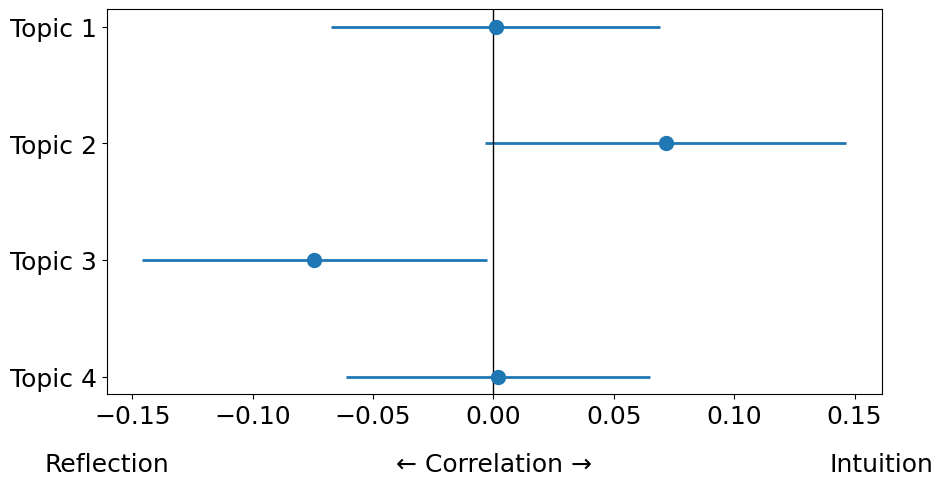

In [42]:
# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []
topics_lda.columns=['Topic 1','Topic 2','Topic 3','Topic 4','treatment'] 

# Run a linear regression for each topic dummy
for column in topics_lda.columns:
    if column != 'treatment':
        X = topics_lda['treatment']
        y = topics_lda[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

#Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2
# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

topic_order=np.arange(len(coefficients),0,-1)-1

plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)
plt.yticks(topic_order, topics_lda.columns[topics_lda.columns != 'treatment'],fontsize=font_size)

# Get the current limits of the x-axis
xmin, xmax = plt.xlim()

# Define x-axis labels and their positions
labels = ['Reflection', u'\u2190 Correlation \u2192', 'Intuition']  # Unicode characters for left and right arrows
positions = [xmin, (xmin + xmax) / 2, xmax]  # Place 'Correlation' at the middle of the x-axis

# Add new x-axis labels
for pos, label in zip(positions, labels):
    plt.text(pos, -0.15, label, fontsize=font_size, ha='center', va='top', transform=plt.gca().get_xaxis_transform())

# Increase font size for original x-axis labels
plt.xticks(fontsize=font_size)

plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'lda_topic_tdm.png',bbox_inches='tight')
plt.show()


